# Imports

In [1]:
import sys
sys.path.append("../common/")

import pandas as pd
import numpy as np
import statsmodels as sm
from datetime import datetime

from statsmodels.regression.linear_model import OLS
from scipy.stats import pearsonr, bootstrap

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

import psycopg
from utility import describe_table, SECRETS, CONNECTION_STRING

# Plot data

## Preprocessing

In [15]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

{'nasdaq_ohlc': None,
 'bitcoin_ohlc': None,
 'snp_ohlc': None,
 'dow_jones_ohlc': None,
 'gold_ohlc': None,
 'oil_price': None}

In [16]:
# can't handle oil
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            SELECT
                bucket::date,
                avg(close) AS avg_close
            FROM (
                SELECT
                    {dt_selector},
                    time_bucket('1 month'::INTERVAL, {dt_selector}) AS bucket,
                    close
                FROM "{asset}"
            )
            GROUP BY bucket
            ORDER BY bucket;
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data.sort_index()
del data

In [17]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        SELECT
            bucket::date,
            avg(price) AS avg_price
        FROM (
            SELECT
                time_bucket('1 month'::INTERVAL, dt) AS bucket,
                price
            FROM oil_price
        )
        GROUP BY bucket
        ORDER BY bucket;
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data.sort_index()
del data

In [18]:
price_data = pd.concat(
    assets.values(),
    axis="columns"
)[:"2025-07-01"]
price_data

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-01-01,2267.774722,NaN,1123.581582,10471.235300,1116.826300,78.325789
2010-02-01,2194.440006,NaN,1089.159989,10214.506271,1098.189479,76.387368
2010-03-01,2362.243896,NaN,1152.048690,10677.518767,1114.356525,81.203478
2010-04-01,2475.720017,NaN,1197.316185,11052.147647,1151.452375,84.292857
2010-05-01,2319.239001,NaN,1125.062006,10500.127002,1203.955005,73.743500
...,...,...,...,...,...,...
2025-03-01,17828.026507,85034.729655,5683.983352,42092.128720,2986.409528,68.239048
2025-04-01,16678.459728,86303.044444,5369.495722,39876.327753,3211.152367,63.536667
2025-05-01,18642.369234,103348.610215,5810.919480,41864.245350,3280.738095,62.167619


In [6]:
first_values = price_data.dropna(axis="rows").iloc[0]
first_values

nasdaq_ohlc        2743.795007
bitcoin_ohlc          6.260668
snp_ohlc           1300.578015
dow_jones_ohlc    12550.986523
gold_ohlc          1660.195001
oil_price           100.273500
Name: 2012-01-01 00:00:00, dtype: float64

In [7]:
norm_data = price_data / first_values

## Plotting

In [8]:
style_frame = pd.DataFrame(
    {
        "alias": ["bitcoin_ohlc", "nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price"],
        "asset_name": ["Bitcoin", "NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
        "color": ["#ff0000", "#0092BC", "#2F4F4F", "#62250B", "#E88F09", "#000000"],
        "style": ["solid"] * 6,
        "alpha": [1] * 6,
        "size": [2] * 6,
        "text_offset": [0, 0.15, 0.1, -0.05, -0.05, 0]
    }
)
style_frame = style_frame.set_index("alias")
style_frame

,asset_name,color,style,alpha,size,text_offset
alias,,,,,,
bitcoin_ohlc,Bitcoin,#ff0000,solid,1,2,0.00
nasdaq_ohlc,NASDAQ,#0092BC,solid,1,2,0.15
snp_ohlc,S&P 500,#2F4F4F,solid,1,2,0.10
dow_jones_ohlc,Dow Jones,#62250B,solid,1,2,-0.05
gold_ohlc,Gold,#E88F09,solid,1,2,-0.05
oil_price,Oil,#000000,solid,1,2,0.00


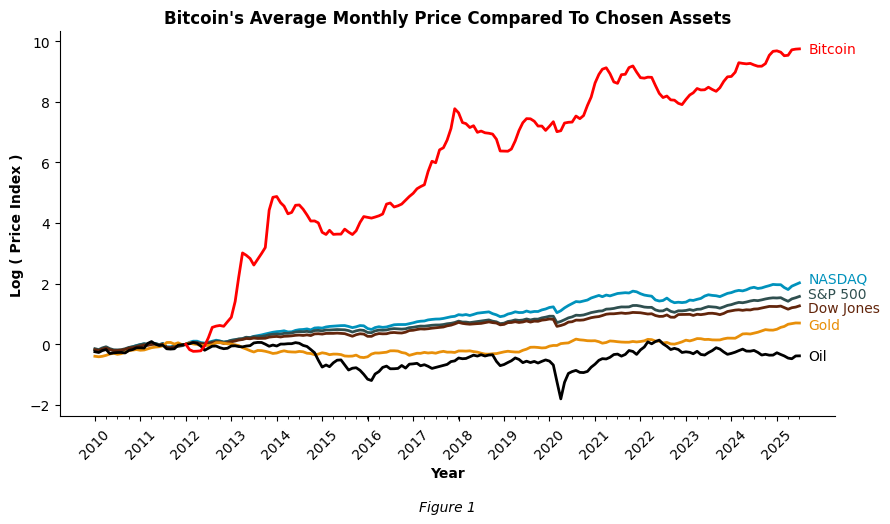

In [9]:
from math import log

# Global >>>
bg_color = "#FFFFFF"

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(
    "Bitcoin's Average Monthly Price Compared To Chosen Assets",
    weight="bold"
)
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
# <<<

# Plotting >>>
new_index_order = ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]
iter_data = norm_data.map(log).reindex(columns=new_index_order).items()
for name, asset in iter_data:
    style = style_frame.loc[name]
    ax.plot(
        asset,
        label=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"],
        linewidth=style["size"],
        linestyle=style["style"]
    )

    ax.text(
        x=asset.index[-1] + pd.offsets.Day(70),
        y=asset.iloc[-1] - 0.15 + style["text_offset"],
        s=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"]
    )
# <<<

# X-axis >>>
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.set_xticks(
    pd.date_range(start="2010-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
ax.set_xticklabels(np.arange(2010,2026))

arr = norm_data.index.to_numpy()
quarters = pd.date_range(start=arr[0],end=arr[-1], freq="QE-DEC").to_numpy()
ax.set_xticks(quarters, minor=True)

ax.set_xlabel(
    "Year",
    weight="bold",
)

ax.text(
    x=(ax.get_xlim()[1] + ax.get_xlim()[0]) / 2,
    y=-5.5,
    s="Figure 1",
    ha="center",
    style="italic"
)
# <<<

# Y-axis >>>
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    "Log ( Price Index )",
    weight="bold"
)
# <<<
pass

## Summary

* The data presented on the chart is normalized w.r.t. to (average) price of each asset in January 2012 and logarithimed. This was done for 2 reasons:
    * Differences in prices in 2012 and subsequent years and 
    * due to enourmous growth of Bitcoin in the last decade.
* Interpretation of the chart:
$$ROI_{k;t} := P_{k;t} - 1$$

$$d_{m;n} := ln(P_{m;n})$$

$$ROI_{k;t} = \frac{P_{0;t}}{P_{0;k}} - 1$$

$$ROI_{k;t} =  \frac{e^{d_{0;t}}}{e^{d_{0;k}}} - 1$$

$$ROI_{k;t} =  e^{d_{0;t}-d_{0;k}} - 1$$

Where each point on the chart is $(x; y) = (x; d_{2012;x})$\
* Thus, the interpretation is: $ ROI_{k;t} =  e^{y_t - y_k} - 1$
* This is however a relatively complex interpretation. The main goal of the chart is to compare price developments of Bitcoin and other chosen assets in appropriate manner 
* Coming at 1,702,630.84% (I) growth over the last ~13 years period Bitcoin's returns shadow any asset in a similar timeframe.
* Such comparisons are however very naive since Bitcoin was founded in 2009, which makes it, in the grand scheme of things, a brand new investment tool
* Remarkably, Bitcoin's growth has been very stable across the years resulting in ~5,38% a month. While other assets have experiences more stable growth rates (II) of about ~1% a month, they once again did not come close to Bitcoin's return
* It's needless to say, that past returns do not gurantee future growth especially amidst increased global uncertainty and regulation

* We will consider "real" returns (as in inflation-free) later in our analysis

### I

In [10]:
((price_data.iloc[-1] / first_values - 1) * 100).round(2).astype(str) + "%"

nasdaq_ohlc           657.52%
bitcoin_ohlc      1702630.84%
snp_ohlc              384.13%
dow_jones_ohlc        254.55%
gold_ohlc             101.29%
oil_price              -31.8%
dtype: object

### II

In [21]:
subset = price_data.reset_index(drop=True).map(log)
subset["const"] = 1
subset["X"] = np.arange(1,len(subset)+1)
subset

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price,const,X
0,7.726554,NaN,7.024277,9.256387,7.018246,4.360877,1,1
1,7.693682,NaN,6.993162,9.231564,7.001418,4.335817,1,2
2,7.767367,NaN,7.049297,9.275896,7.016032,4.396958,1,3
3,7.814287,NaN,7.087838,9.310380,7.048779,4.434297,1,4
4,7.748994,NaN,7.025593,9.259143,7.093367,4.300593,1,5
...,...,...,...,...,...,...,...,...
182,9.788527,11.350815,8.645408,10.647616,8.001827,4.223017,1,183
183,9.721873,11.365620,8.588489,10.593538,8.074385,4.151617,1,184
184,9.833192,11.545863,8.667494,10.642187,8.095824,4.129834,1,185
185,9.887018,11.568557,8.704494,10.663193,8.116996,4.221990,1,186


In [22]:
for asset in ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]:
    frame = subset[["const","X",asset]]
    frame = frame.dropna(axis="rows")
    
    res = OLS(
        exog=frame[["const","X"]].to_numpy(),
        endog=frame[asset].dropna().to_numpy(),
        hasconst=True
    ).fit()
    
    print(
        res.summary(
            yname=f"Log price",
            xname=["Constant", "Month"],
            title=f"{asset} summary",
            alpha=0.01,
            slim=True
        ),
        end="\n\n\n"
    )

                             nasdaq_ohlc summary                              
Dep. Variable:              Log price   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
No. Observations:                 187   F-statistic:                     7223.
Covariance Type:            nonrobust   Prob (F-statistic):          3.46e-150
                 coef    std err          t      P>|t|      [0.005      0.995]
------------------------------------------------------------------------------
Constant       7.6763      0.015    507.356      0.000       7.637       7.716
Month          0.0119      0.000     84.989      0.000       0.011       0.012

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


                               snp_ohlc summary                               
Dep. Variable:              Log price   R-squared:                       0.979
Model:                       

# Inflation adjusted price

## Preprocessing

In [23]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute("""
    SELECT
    	dt,
    	value / first(value, dt) over(order by dt) as normalized_cpi
    FROM cpi
    where dt between '2012-01-01' and '2025-07-01';
    """)

cpi = (pd
    .DataFrame(res.fetchall(),columns=["date", "cpi"])
    .astype({"date":"datetime64[ns]"})
    .set_index("date")
    .squeeze()
)
cpi.head(3)

date
2012-01-01    1.000000
2012-02-01    1.002137
2012-03-01    1.004235
Name: cpi, dtype: float64

In [24]:
bitcoin_data = dict()

bitcoin_data.update({"nominal": price_data["bitcoin_ohlc"].dropna().copy()})
bitcoin_data.update({"adjusted": bitcoin_data["nominal"] / cpi})

In [25]:
snp_data = dict()
snp_data.update({"nominal": price_data.loc["2012-01-01":,"snp_ohlc"]})
snp_data.update({"adjusted": snp_data["nominal"] / cpi})

## Plotting

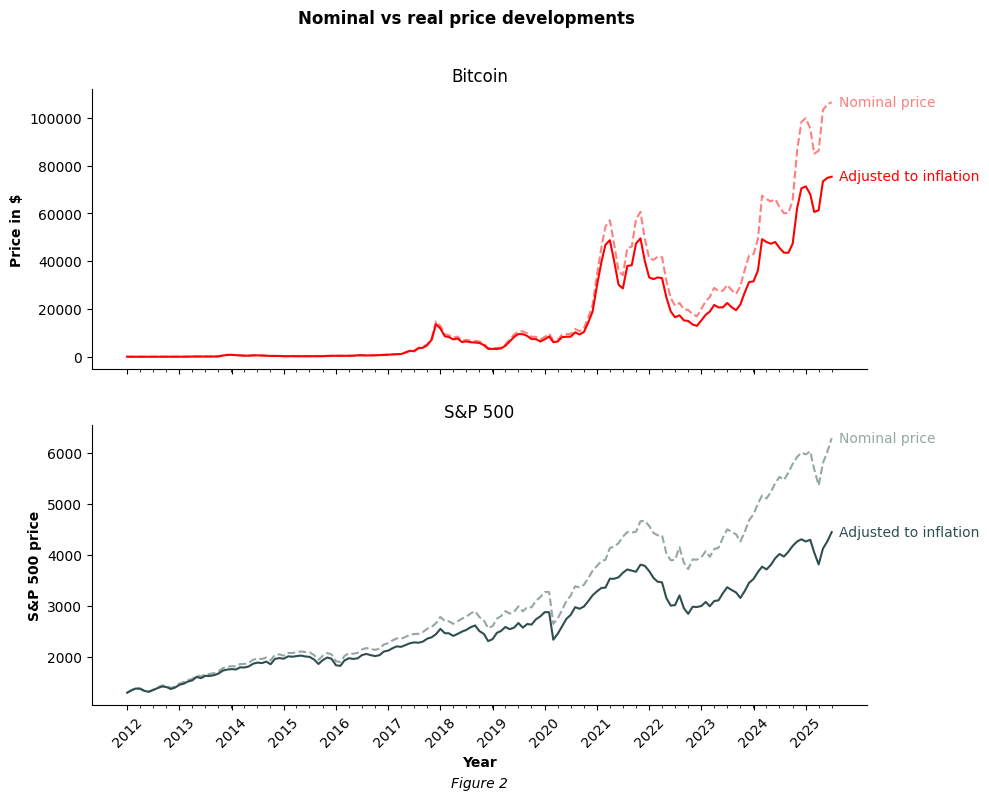

In [27]:
titles = [
    "Bitcoin",
    "S&P 500"
]
ylabels = ["Price in $", "S&P 500 price"]
assets = [bitcoin_data, snp_data]

# Global >>>
bg_color = "#FFFFFF"
base_colors = ["red", "#2F4F4F"]

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True
)

fig.set_facecolor(bg_color)

fig.suptitle(
    "Nominal vs real price developments",
    weight="bold"
)
# <<<

# Plotting >>>
for ax, asset, color, title, ylabel in zip(axes, assets, base_colors, titles, ylabels):
    ax.set_facecolor(bg_color)
    ax.set_title(title)

    # Nominal
    ax.plot(
        asset["nominal"],
        color=color,
        linestyle="--",
        alpha=0.5
    )

    ax.text(
        x=asset["nominal"].index[-1] + pd.offsets.Day(50),
        y=asset["nominal"].iloc[-1],
        s="Nominal price",
        color=color,
        alpha=0.5,
        va="center"
    )

    # Adjusted
    ax.plot(
        asset["adjusted"],
        color=color,
        linestyle="-",
        alpha=1.0
    )

    ax.text(
        x=asset["adjusted"].index[-1] + pd.offsets.Day(50),
        y=asset["adjusted"].iloc[-1],
        s="Adjusted to inflation",
        color=color,
        alpha=1.0,
        va="center"
    )

    # Axis styling >>>
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_ylabel(
        ylabel,
        weight="bold"
    )
    # <<<
# <<<

# X-axis (shared) >>>
axes[-1].tick_params(axis="x", labelrotation=45)

axes[-1].set_xticks(
    pd.date_range(start="2012-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
axes[-1].set_xticklabels(np.arange(2012, 2026))

arr = bitcoin_data["nominal"].index.to_numpy()
quarters = pd.date_range(start=arr[0], end=arr[-1], freq="QE-DEC").to_numpy()
axes[-1].set_xticks(quarters, minor=True)

axes[-1].set_xlabel(
    "Year",
    weight="bold"
)

axes[-1].text(
    x=(axes[-1].get_xlim()[1] + axes[-1].get_xlim()[0]) / 2,
    y=axes[-1].get_ylim()[0] - 1600,
    s="Figure 2",
    ha="center",
    style="italic"
)
# <<<
pass

## Summary
* S&P 500 taken as a reference, since other assets like indices have developed in a similar fashion
* We can see that real and nominal prices did not diverge rapidly before 2020, since the inflation rate was low
* In 2020 real and normial price of S&P 500 diverged, since inflation increased substantially
* It's important to notice that the visual difference in returns is purely visual, the actual ratio of returns for each asset stays the same (I)

### I


In [34]:
bitcoin_data["nominal"].iloc[-1] / bitcoin_data["adjusted"].iloc[-1]

np.float64(1.4138394150332245)

In [33]:
snp_data["nominal"].iloc[-1] / snp_data["adjusted"].iloc[-1]

np.float64(1.4138394150332245)

# Calculate CV

## Preprocessing

In [35]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

{'nasdaq_ohlc': None,
 'bitcoin_ohlc': None,
 'snp_ohlc': None,
 'dow_jones_ohlc': None,
 'gold_ohlc': None,
 'oil_price': None}

In [36]:
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            SELECT
            	time_bucket('1 year'::interval, {dt_selector}) as bucket,
            	stddev_samp(close) / avg(close) as cv
            FROM {asset}
            group by bucket;
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data

In [37]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        SELECT
            time_bucket('1 year'::interval, dt) as bucket,
            stddev_samp(price) / avg(price) as cv
        FROM oil_price
        group by bucket;
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data

In [38]:
cv_data = pd.concat(assets.values(), axis=1)[:"2025-07-01"]
cv_data

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-01-01,0.062928,NaN,0.049301,0.043082,0.080499,0.066088
2011-01-01,0.045995,NaN,0.049345,0.041012,0.093802,0.085146
2012-01-01,0.038007,0.379583,0.033803,0.024634,0.038191,0.082165
2013-01-01,0.086735,1.292875,0.060369,0.047684,0.104004,0.055740
2014-01-01,0.048461,0.273089,0.041326,0.032943,0.040102,0.145383
2015-01-01,0.031845,0.216284,0.026630,0.031539,0.049242,0.140324
2016-01-01,0.059546,0.242342,0.048422,0.052588,0.057992,0.155680
2017-01-01,0.063189,0.997283,0.044677,0.060781,0.027190,0.077210
2018-01-01,0.049964,0.320137,0.036563,0.033095,0.042714,0.100107


In [39]:
# Bitcoin False due to handling of NA values
(cv_data >= 0).all(axis="rows")

nasdaq_ohlc        True
bitcoin_ohlc      False
snp_ohlc           True
dow_jones_ohlc     True
gold_ohlc          True
oil_price          True
dtype: bool

In [40]:
# After dropping NA values the >= 0 condition holds
(cv_data["bitcoin_ohlc"].dropna() >= 0).all(axis="rows")

np.True_

## Plotting

In [41]:
style_frame = pd.DataFrame(
    {
        "alias": ["bitcoin_ohlc", "nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price"],
        "asset_name": ["Bitcoin", "NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
        "color": ["#ff0000", "#0092BC", "#2F4F4F", "#62250B", "#E88F09", "#000000"],
        "style": ["solid"] * 6,
        "alpha": [1] + [0.2] * 5,
        "size": [2] * 6,
        "text_offset_x": [0, 350, 0, 0, 0, 220],
        "text_offset_y": 0
    }
)
style_frame = style_frame.set_index("alias")
style_frame

,asset_name,color,style,alpha,size,text_offset_x,text_offset_y
alias,,,,,,,
bitcoin_ohlc,Bitcoin,#ff0000,solid,1.0,2,0,0
nasdaq_ohlc,NASDAQ,#0092BC,solid,0.2,2,350,0
snp_ohlc,S&P 500,#2F4F4F,solid,0.2,2,0,0
dow_jones_ohlc,Dow Jones,#62250B,solid,0.2,2,0,0
gold_ohlc,Gold,#E88F09,solid,0.2,2,0,0
oil_price,Oil,#000000,solid,0.2,2,220,0


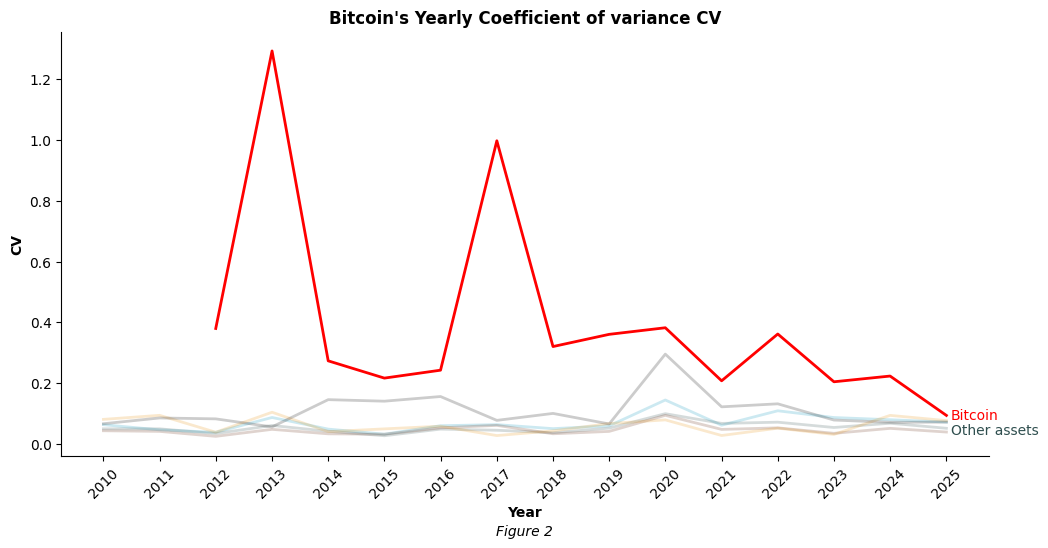

In [42]:
from math import log

# Global >>>
bg_color = "#FFFFFF"

fig, ax = plt.subplots(
    figsize=(10,5),
)
ax.set_title(
    "Bitcoin's Yearly Coefficient of variance CV",
    weight="bold"
)
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
fig.tight_layout()
# <<<

# Plotting >>>
new_index_order = ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]
iter_data = (cv_data
    #.map(log)
    .reindex(columns=new_index_order)
    .items()
    )
for name, asset in iter_data:
    style = style_frame.loc[name]
    ax.plot(
        asset,
        label=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"],
        linewidth=style["size"],
        linestyle=style["style"]
    )

ax.text(
    x=cv_data.index[-1] + pd.offsets.Day(30),
    y=cv_data.iloc[-1,1],
    s=style_frame.loc["bitcoin_ohlc", "asset_name"],
    color=style_frame.loc["bitcoin_ohlc", "color"],
    alpha=style_frame.loc["bitcoin_ohlc", "alpha"],
    va="center",
    ha="left"
)

ax.text(
    x=cv_data.index[-1] + pd.offsets.Day(30),
    y=cv_data.iloc[-1,1] - 0.05,
    s="Other assets",
    color=style_frame.loc["snp_ohlc", "color"],
    alpha=1,
    va="center",
    ha="left"
)
# <<<

# X-axis >>>
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.set_xticks(
    pd.date_range(start="2010-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
ax.set_xticklabels(np.arange(2010,2026))

ax.set_xlabel(
    "Year",
    weight="bold",
)

ax.text(
    x=(ax.get_xlim()[1] + ax.get_xlim()[0]) / 2,
    y=-0.3,
    s="Figure 2",
    ha="center",
    style="italic"
)
# <<<

# Y-axis >>>
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    "CV",
    weight="bold"
)
# <<<
pass

## Summary

* The figure show development of log coefficient of variance CV of assets over time
$$CV_i = \frac{\sigma_i}{\mu_i} $$
* This metric has been used in order to enable standartized and comparable analysis

* As Bitcoin's market cap grew, volatility fell. This makes sense since the market became more heterogenous and thus less correlated
* Having said that however Bitcoin remains highly volatile in absolute and relative terms
* Possible reason being speculativity

# Correlation

### Preprocessing

In [43]:
corr_matrix = price_data.corr().rename(
    columns={"nasdaq_ohlc":"NASDAQ", "bitcoin_ohlc":"Bitcoin", "snp_ohlc":"S&P 500", "dow_jones_ohlc":"Dow Jones", "gold_ohlc":"Gold", "oil_price":"Oil"},
    index={"nasdaq_ohlc":"NASDAQ", "bitcoin_ohlc":"Bitcoin", "snp_ohlc":"S&P 500", "dow_jones_ohlc":"Dow Jones", "gold_ohlc":"Gold", "oil_price":"Oil"}
)
corr_matrix

,NASDAQ,Bitcoin,S&P 500,Dow Jones,Gold,Oil
NASDAQ,1.000000,0.925308,0.994683,0.984261,0.807565,-0.125105
Bitcoin,0.925308,1.000000,0.922733,0.883168,0.900249,0.100957
S&P 500,0.994683,0.922733,1.000000,0.992190,0.796598,-0.121418
Dow Jones,0.984261,0.883168,0.992190,1.000000,0.747327,-0.153134
Gold,0.807565,0.900249,0.796598,0.747327,1.000000,0.130199
Oil,-0.125105,0.100957,-0.121418,-0.153134,0.130199,1.000000


### Plotting

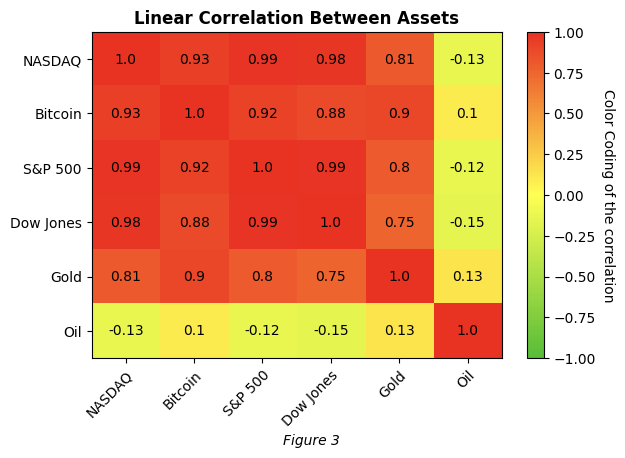

In [57]:
# source https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
index = corr_matrix.index
columns = corr_matrix.columns

matrix = corr_matrix.to_numpy().round(2)

cmap = LinearSegmentedColormap.from_list(
    "custom_redgreen",
    [
        (0.00, (0.34, 0.74, 0.22)),   # green at -1
        (0.50, (1, 1, 0.33)),  # yellow at  0
        (1.00, (0.91, 0.2, 0.14)),  # red at +1
    ]
)
norm = Normalize(vmin=-1, vmax=1)

fig, ax = plt.subplots()
im = ax.imshow(
    matrix,
    cmap=cmap,
    norm=norm,
    aspect="auto"
)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(columns)), labels=columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(index)), labels=index)

ax.text(
    2.3,
    7.1,
    "Figure 3",
    style="italic"
)

# Loop over data dimensions and create text annotations.
for i in range(len(index)):
    for j in range(len(columns)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="black")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap=cmap)
cbar.ax.set_ylabel("Color Coding of the correlation", rotation=-90, va="bottom")

ax.set_title("Linear correlation between assets".title(), weight="bold")
fig.tight_layout()
pass

### Summary

* Assets are all highly correlated except for oil
* Reason: NASDAQ, S&P as well as Bitcoin are all in the tech space, so it would make sense for them to be highly correlated
* Interestingly enough gold also has a very high correlation with every asset besides oil
* Possible reason: ease of access and thus speculative nature, whereby oil is less of a speculative assset

# Monthly price change

Test hypotheses:
$$H_0: R_i ≤ 1$$
$$H_1: R_i > 1$$

With
$$
R_i = \frac{\sigma_{BTC}}{\sigma_i}, i \in \{Nasdaq,~S\&P~500,~Dow~Jones,~Gold,~Oil\}
$$
And $\alpha = 0.01$

## Preprocessing

In [ ]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

In [ ]:
# can't handle oil
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            with monthly_avg as (
            	SELECT
            		time_bucket('1 month'::interval, {dt_selector}) as bucket,
            		avg(close) as avg_close
            	FROM {asset}
            	group by bucket
            )
            
            SELECT
            	bucket,
            	avg_close /
            	lag(avg_close) over(order by bucket) - 1 as pct_change
            FROM monthly_avg
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","pct_change"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data.sort_index()

In [ ]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        with monthly_avg as (
            SELECT
                time_bucket('1 month'::interval, dt) as bucket,
                avg(price) as avg_close
            FROM oil_price
            group by bucket
        )
        
        SELECT
            bucket,
            avg_close /
            lag(avg_close) over(order by bucket) - 1 as pct_change
        FROM monthly_avg
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data.sort_index()

In [ ]:
pct_changes = pd.concat(
    assets.values(),
    axis="columns"
)["2010-02-01":"2025-07-01"]
pct_changes

## Computing bootstrap CI

Could not find appropriate distribution for Bitcoin, thus falling back to bootstrap method\
Assumming i.i.d sample

In [ ]:
def get_R(*samples, axis) -> float:
    """
    Takes in 5 assets as separate arguments:
        - nasdaq
        - s&p
        - dow jones
        - gold
        - oil
    in this order.
    Each asset data contains int(n_resamples) samples, each len(data)-sized
    Outputs t-statistic for each of them
    """ 
    return pct_changes["bitcoin_ohlc"].std(ddof=1) / np.array(samples).std(axis=-1, ddof=1)

result = bootstrap(
    data=pct_changes.drop(columns="bitcoin_ohlc").T.to_numpy(),
    statistic=get_R,
    n_resamples=300_000,
    vectorized=True,
    axis=0,
    paired=True,
    confidence_level=0.99, # to test for alpha, using a one-sided CI. Thus alpha is not doubled
    alternative="greater"
)
print("Sucess!")

In [ ]:
from tabulate import tabulate

df_ = pd.DataFrame(
    result.confidence_interval,
    columns=["NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
    index=["Lower","Upper"]
)
print(tabulate(df_,headers='keys'))

## Plot Resample distribution

In [ ]:
PLOT_DATA = (pd
    .DataFrame(result.bootstrap_distribution.T)
    .rename(columns={0:"NASDAQ", 1:"S&P 500", 2:"Dow Jones", 3:"Gold", 4:"Oil"})
)
PLOT_DATA.info()

In [ ]:
# Column order
columns = PLOT_DATA.columns.tolist()

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 6)

fig.suptitle("Bootstrap distribution of test statistic R".title(), fontsize=16, fontweight="bold")

# --- Top row: three equal charts ---
ax_top = [
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6])
]

# --- Bottom row: padded, centered charts ---
ax_bottom = [
    fig.add_subplot(gs[1, 1:3]),  # left bottom
    fig.add_subplot(gs[1, 3:5])   # right bottom
]

axes = ax_top + ax_bottom

for col, ax in zip(columns, axes):
    data = PLOT_DATA[col]
    mean_val = data.mean()

    # Histogram
    ax.hist(data, bins=50, density=True, color="#408CFF")

    # Mean line
    ax.axvline(mean_val, linestyle="--", color="black", linewidth=1)

    # Titles and labels
    ax.set_title(col, fontweight="bold")
    ax.set_xlabel("R-value", fontweight="bold")
    ax.set_ylabel("Density", fontweight="bold")

    # Mean annotation below x-axis
    ax.annotate(
        f"{mean_val:.2f}",
        xy=(mean_val, 1),
        xycoords=("data", "axes fraction"),
        xytext=(10, -10),
        textcoords="offset points",
        ha="left",
        va="top",
        color="black"
    )


# White background
fig.patch.set_facecolor("white")
for ax in axes:
    ax.set_facecolor("white")

plt.tight_layout(rect=[0, 0, 1, 0.95])

## Summary
$H_0$ is discarded for each asset.\
Thus Bitcoin's variance is significantly higher than each individual variance

# Summary
* Bitcoin's growth in the recent years has been fueled by surge in popularity and increase in addoption
* All assets have outpeformed inflation altought the growth in the recent years has been reduced by infaltion
* It is important to notice that past performance ≠ future returns
* Even though the Bitcoin is signifinifactly more volatile than each other asset, the volatility has been falling over the years